In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import time
import itertools
import numpy as np

# Torch
import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
print("Torch Version:", torch.__version__)

import matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import sem
from tensorflow.examples.tutorials.mnist import input_data
import sys
from simple_rl.tasks.navigation.NavigationWorldMDP import *

sys.path.append("../../")
sys.path.append("../../Datasets/")
from utils.ImageSampler import ImageSampler

Torch Version: 1.1.0


ModuleNotFoundError: No module named 'tensorflow.examples.tutorials'

In [2]:
from xview.xview_wrapper import MicroXView
use_grayscale = True
input_shape = [32, 32, 1] if use_grayscale else [32, 32, 3]

img_data = MicroXView(one_hot=False, shuffle=True, use_grayscale=use_grayscale, 
                     dataset_dir="../../Datasets/xview/xView_data/micro-xview-v1/")
img_sampler = ImageSampler(img_data)
sample_train_img_seq = lambda c_lst: np.reshape(img_sampler.sample_image_train(c_lst), [-1] + input_shape)
sample_test_img_seq = lambda c_lst: np.reshape(img_sampler.sample_image_test(c_lst), [-1] + input_shape)
class_label_to_id = {v:k for k,v in img_data.class_id_to_label.items()}

In [3]:
# Visualization functions 
import io
import imageio
from PIL import Image
from IPython import display

def read_pil_image_from_plt(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return Image.open(buf)

def create_gif(img_generator, cmap=plt.cm.viridis, gif_name="./__gif_sample.gif", fps=10,
               figsize=(4, 4), title=None, display=False):
    with imageio.get_writer(gif_name, mode='I', fps=fps) as writer:
        for img in img_generator():
            # Append to GIF
            writer.append_data(np.array(img))
            
            # Wait to draw - only for online visualization
            if display:
                plt.imshow(img)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        plt.clf()
    return

def convert_to_grid(nvmdp, S, state_values):
    
    grid = np.zeros((nvmdp.height, nvmdp.width))
    
    for si, s in enumerate(S):
        x, y = s
        row, col = nvmdp._xy_to_rowcol(x, y)
        grid[row, col] = state_values[si]
    return grid

def get_grad_evolution_images(nvmdp, S, R_grid, expert_traj, R_grads_evolution, boltzmann_temp, 
                              figsize=(40,20), R_kind=""):

    for i in range(len(R_grads_evolution)):
        
        plt.close('all')
        plt.figure(figsize=figsize)
        nvmdp.visualize_grid(R_grid, trajectories=expert_traj, cmap=plt.cm.Reds_r,
                             state_space_cmap=False, show_colorbar=True, fig=fig, subplot_str="121",
                             title="Navigation IRL MDP(with true reward). Expert Path (black).", end_marker="*c")
        nvmdp.visualize_grid(convert_to_grid(nvmdp, S, R_grads_evolution[i]), trajectories=[expert_traj[0][:i+1]], 
                             state_space_cmap=False,  traj_marker='-b',
                             cmap=plt.cm.Reds_r, show_colorbar=True, fig=fig, subplot_str="122",
                             title="MLIRL Gradients. {}, temp: {}, step: {}.".format(R_kind, boltzmann_temp, i+1))
        yield read_pil_image_from_plt(plt)
        plt.clf()

def plot_irl_gridworld(nvmdp, phi, state_ids, fig, subplot_str="32", plot_idx=1):
    
    cdict = {0: "lightgrey", 1: "red"}
    group = state_ids
    labels = {0: "road", 1: "obstacle"}
    ax = fig.add_subplot(subplot_str + str(plot_idx))
    fig, ax = nvmdp.visualize_grid(trajectories=trajectories_states, 
                         state_space_cmap=True,
                         show_rewards_colorbar = True,
                         cmap=plt.cm.Reds_r, 
                         show_colorbar=True, 
                         init_marker=".",
                         end_marker="*", 
                         traj_linewidth=2,
                         fig=fig, ax=ax, plot=False)

    ax = fig.add_subplot(subplot_str + str(plot_idx+1))
    for g in np.unique(group):
        ix = np.where(group == g)
        ax.scatter(phi[ix,0], phi[ix,1], c = cdict[g], label = labels[g], s = 50)
    # plt.scatter(phi[:,0], phi[:,1], c=[colors[s] for s in state_ids], g=state_ids, label=["obstacle", "drivable"])
    plt.tight_layout()
    plt.title("Features")
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend()
    
def plot_irl_results(nvmdp, fig, R_rec, loss_history, is_loglik_loss=True,
                     title="MLIRL (specifics)", subplot_str="32", plot_idx=3, ylabel=""):
    
    ax = fig.add_subplot(subplot_str + str(plot_idx))
    fig, ax = nvmdp.visualize_grid(R_rec, trajectories=trajectories_states, 
                         state_space_cmap=False,
                         show_rewards_colorbar=False,
                         cmap=plt.cm.gray, 
                         show_colorbar=True, 
                         init_marker=".",
                         end_marker="*", 
                         traj_linewidth=2,
                         fig=fig, ax=ax, plot=False, title=title + ": Recovered Reward")

    ax = fig.add_subplot(subplot_str + str(plot_idx+1))
    
    if is_loglik_loss:
        plt.plot(np.exp(-np.asarray(loss_history)))
        plt.ylabel("Likelihood")
    else:
        plt.plot(loss_history)
        if ylabel:
            plt.ylabel(ylabel)
        else:
            plt.ylabel("Loss")
        
    plt.xlabel("Iterations")
    plt.title(title + ": Training Curve")
    
class RectangularObstacle(object):
    
    def __init__(self, x, y, w, h):
        
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.points = [(x+i, y+j) for j in range(h) for i in range(w)]
    
    def intersects(self, o2):
        
        x1, y1, w1, h1 = o2.x, o2.y ,o2.w, o2.h
        
        # check if rect is on the left or right side of another one
        if self.x + self.w < x1\
            or self.x > x1 + w1:
            return False
        
        # check if rect is on the top or bottom side of another one
        if self.y + self.h < y1 \
            or self.y > y1 + h1:
            return False
        
        return True
    
    def __eq__(self, o2):
        return self.intersects(o2)
        
    def __call__(self):
        return self.points
    
    def __repr__(self):
        return "Obstacle at (x,y) = ({},{}) of size (w,h) = ({},{})".format(self.x, self.y, self.w, self.h)
    
def generate_obstacles(grid_w, grid_h, n_obstacles, 
                       obstacle_w_mu=3, obstacle_w_std=3,
                       obstacle_h_mu=3, obstacle_h_std=3,
                       max_search_tries=100):

    obstacle_list = []
    count = 0
    search_tries = 0
    while count < n_obstacles:
        
        w = int(min(max(np.ceil(np.random.normal(obstacle_w_mu, obstacle_w_std)), 1), grid_w-1))
        h = int(min(max(np.ceil(np.random.normal(obstacle_h_mu, obstacle_h_std)), 1), grid_h-1))
        
        # restrict x, y so that obstacle is inside the desired region
        x, y = np.random.randint(1, grid_w-w+1), np.random.randint(1, grid_h-h+1)
        
        ob = RectangularObstacle(x, y, w, h)
        
        if ob not in obstacle_list:
            obstacle_list.append(ob)
            count += 1
            search_tries = 0
        else:
            search_tries += 1
            if search_tries < max_search_tries:
                continue
            else:
                print("Couldn't find space for more obstacles, generated: {}. Probably that's okay.".format(count))
                break
        
    return obstacle_list

Couldn't find space for more obstacles, generated: 7. Probably that's okay.


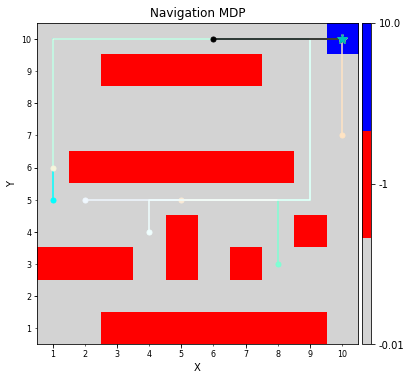

(<Figure size 432x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c4866beb8>)

In [4]:
np.random.seed(1)

obstacle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
W, H = 10, 10
n_obstacles = 10
nvmdp = NavigationWorldMDP(width=W, height=H, 
                    nav_cell_types = ['lightgray', "red"],
                    nav_cell_rewards = [-0.01, -1],
                    nav_cell_p_or_locs = [1., 
                      list(itertools.chain(*[o() for o in generate_obstacles(
                          W, H, n_obstacles, max_search_tries=100, obstacle_w_mu=2, obstacle_h_mu=2)]))],
                    goal_cell_locs=[[(10, 10)]],
                    goal_cell_rewards=[10.],
                    goal_cell_types=["blue"],
                    slip_prob=0.00, step_cost=0.0, gamma=.99)
cell_type_to_class_map = {"red": "Building",
                      "blue": "Cargo Truck", "lightgray": "None"}
state_id_to_class_map = {nvmdp.cell_type_to_id[k]: v for k,v in cell_type_to_class_map.items()}
state_id_to_class_id_map = {nvmdp.cell_type_to_id[k]: class_label_to_id[v] \
                            for k,v in cell_type_to_class_map.items()}

traj_states_list, traj_action_list = nvmdp.sample_trajectories(n_traj=8, horizon=100, 
                                                               init_states=None,
                                                               init_cell_types=["lightgray"], init_unique=True,
                                                               rand_init_to_match_n_traj=True)
nvmdp.visualize_grid(trajectories=traj_states_list, show_colorbar=True, show_rewards_colorbar=True, init_marker=".",
                         end_marker="*")

In [5]:
def sample_train_img_mat(class_id_mat):
    
    img_grid = []
    for class_ids_lst in class_id_mat:
        img_grid.extend(sample_train_img_seq(class_ids_lst))
        
    return np.asarray(img_grid)

def image_stack_to_grid(img_stack, nrow, padding, img_dim):
    """
    Creates image grid of size nrow x (n/nrows) from image stack.

    :param img_stack (numpy array): a set of images in (N x H x W x C) format
    :param nrow: number of rows in grid
    :returns: image sprite with set of images laid out in a grid
    """
    H, W, C = img_dim
    import torch
    from torchvision import utils
    return utils.make_grid(
        torch.tensor(img_stack).permute(0, 3, 1, 2), nrow=nrow, padding=padding).permute(1, 2, 0)

In [6]:
color_to_class_lbl_str = "".join([ "{:>20}: {:<20}\n".format(k.lower(), v.lower()) for k,v in cell_type_to_class_map.items()])
print(color_to_class_lbl_str)

                 red: building            
                blue: cargo truck         
           lightgray: none                



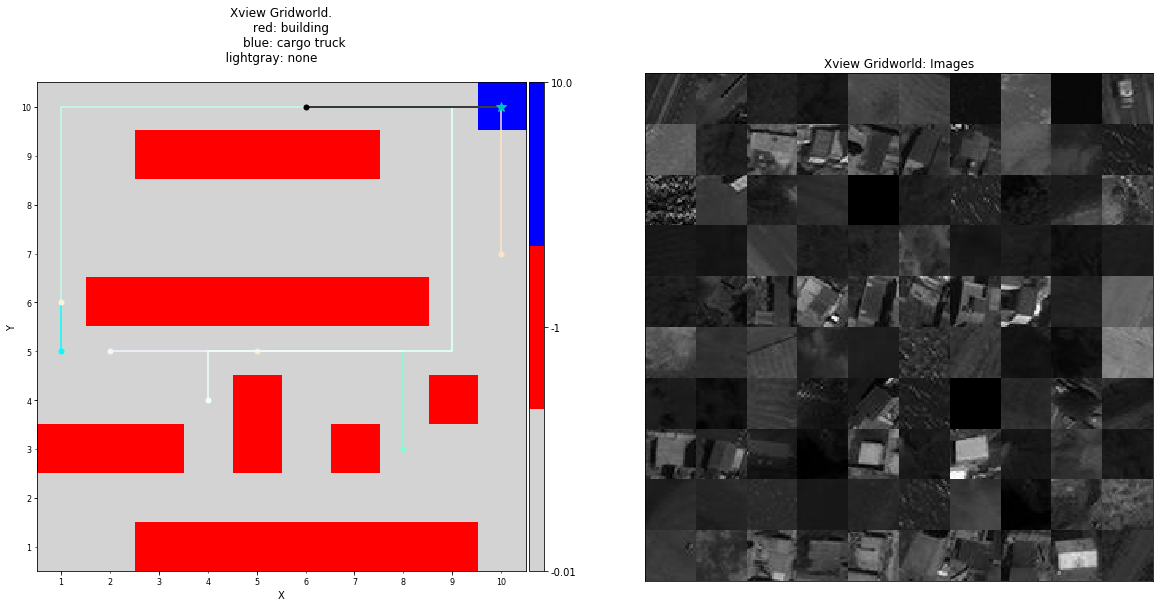

In [7]:
img_stack = sample_train_img_mat([[state_id_to_class_id_map[col] for col in row] for row in nvmdp.map_state_cell_id])
img_grid = image_stack_to_grid(img_stack, nvmdp.height, 0, (32, 32, 1))

fig = plt.figure(figsize=(20,12))
fig, ax = nvmdp.visualize_grid(trajectories=traj_states_list, show_colorbar=True, 
                               show_rewards_colorbar=True, goal_marker="*c", fig=fig, subplot_str="121",
                              title="Xview Gridworld.\n{}".format(color_to_class_lbl_str))
ax = fig.add_subplot(122)
ax.imshow(img_grid.numpy(), cmap="gray", vmin=0, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
_ = ax.set_title("Xview Gridworld: Images")

In [8]:
# for i in range(100):
#     img_stack = sample_train_img_mat([[state_id_to_class_id_map[col] for col in row] for row in nvmdp.map_state_cell_id])
#     img_grid = image_stack_to_grid(img_stack, nvmdp.height, 0, (32, 32, 1))

#     fig = plt.figure(figsize=(20,12))
#     fig, ax = nvmdp.visualize_grid(trajectories=traj_states_list, show_colorbar=True, 
#                                    show_rewards_colorbar=True, goal_marker="*c", fig=fig, subplot_str="121",
#                                   title="Xview Gridworld.\n{}".format(color_to_class_lbl_str))
#     ax = fig.add_subplot(122)
#     ax.imshow(img_grid.numpy(), cmap="gray", vmin=0, vmax=1)
#     ax.set_xticks([])
#     ax.set_yticks([])
#     _ = ax.set_title("Xview Gridworld: Images")
#     plt.savefig("./gif2/XviewGridWorld_{:03d}.png".format(i))

In [120]:
S = nvmdp.get_all_states()
s_to_idx = {tuple(v):k for k,v in enumerate(S)}
R_s = nvmdp._reward_func_state_only
R = torch.tensor([R_s(s) for s in S], requires_grad=True)
R_grid = convert_to_grid(nvmdp, S, R)
A = nvmdp.get_actions()
a_to_idx = {a:i for i,a in enumerate(A)}
T = nvmdp.transition_func
shortest_path_fn = lambda s, g: Planners.astar_find_path(s, g, A, T, cost_fn=lambda s: -R_s(s))

trajectories = [list(zip(traj_states_list[i], traj_action_list[i])) for i, traj in enumerate(traj_states_list)]
# Features
state_ids = [nvmdp.map_state_cell_id[tuple(nvmdp._xy_to_rowcol(*s))] for s in S]
# linear_phi = torch.FloatTensor([state_id_to_linear_feature(s_id) for s_id in state_ids])
# non_linear_phi = torch.FloatTensor([state_id_to_non_linear_feature(s_id) for s_id in state_ids])
# one_hot_phi = torch.FloatTensor([nvmdp.feature_at_state(s) for s in S])
image_phi = torch.FloatTensor([sample_train_img_seq([state_id_to_class_id_map[s_id]]).squeeze() for s_id in state_ids])

phi = image_phi
phi_fn = lambda s: phi[s_to_idx[tuple(s)]]

In [148]:
def states_generator(trajectory):
    return S

def dynamics_generator(trajectory):
    return lambda s,a: [(T(s,a), 0)]

In [94]:
sys.path.append("../../Learning/")
import Models as Models

sys.path.append("../../utils/")

sys.path.append("../../MLIRL/")
from MLIRL.MLIRL import *

sys.path.append("../../Planning/")

# MaxEnt
sys.path.append("../../MaxEntIRL")
from MaxEntIRL.MaxEntIRL import *

Text(0.5, 1.0, 'State visitation frequency')

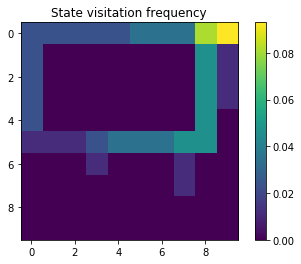

In [13]:
plt.imshow(nvmdp.convert_array_to_grid(compute_svf(trajectories, S), S))
plt.colorbar()
plt.title("State visitation frequency")

Text(0.5, 1.0, 'Feature expectations')

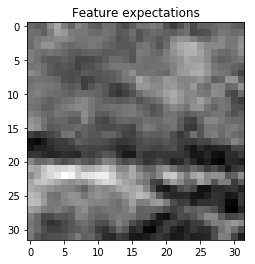

In [39]:
plt.imshow(compute_feature_expectations(trajectories, phi_fn, s_to_idx, a_to_idx), cmap="gray")
plt.title("Feature expectations")

In [45]:
phi_dim = len(phi_fn(S[0]))

In [150]:
temperature = 0.1
lr, weight_decay = 0.1, 0
gamma = 0.95
n_vi_iters = 400
n_maxent_iters = 50

np.random.seed(1)
torch.manual_seed(1)
# R model
R_model = Models.LinearRewardModel_Tanh(phi_dim, 0)
for p in R_model.parameters():
    print(p)
# Test: non-positive R
# assert np.alltrue(np.asarray([R_model(torch.FloatTensor(x)).item() for x in np.random.uniform(-10,10,(100,phi_dim))]) <= 0)
# Optimizer
optimizer_fn=lambda params, lr, weight_decay: optim.Adam(params, lr=lr, weight_decay=weight_decay)
R_optimizer = optimizer_fn(R_model.parameters(), lr, weight_decay)
policy = lambda Q, temp=temperature: Planners.log_boltzmann_dist(Q, temp)

maxent_loss_history = MLIRL(trajectories, states_generator, dynamics_generator, A, phi_fn, 
                                R_model, R_optimizer, policy, gamma, n_maxent_iters, n_vi_iters)

Parameter containing:
tensor([[ 0.0911, -0.0780, -0.0343,  0.0830, -0.1664,  0.1060, -0.0364,  0.0899,
          0.0246, -0.0216,  0.0490,  0.0087,  0.0646, -0.0689, -0.0129, -0.0159,
          0.0256, -0.0007,  0.1545,  0.0550, -0.0658, -0.1068, -0.0296, -0.0763,
         -0.0566,  0.0085,  0.1054,  0.0961, -0.1728,  0.1096,  0.0494,  0.1677]],
       requires_grad=True)
MLIRL params 
-----
	 Domains: 8, sizes: [100, 100, 100, 100, 100, 100, 100, 100],
	 Action dim: 4, 
	 Feature dim: 32,
	 Iterations: 50, 
	 Max likelihood: 0.99,
	 VI iterations: 200, 
	 VI convergence eps: 0.001,
	 Gamma (discount factor): 0.95, 
	 Policy example: Q tensor([0.0000, 0.3333, 0.6667, 1.0000]) -> Pi tensor([-10.0363,  -6.7030,  -3.3697,  -0.0363])
R max:  0.16635897755622864  R min:  0.0
Running VI [  ] VI converged @ 1.
V max:  0.16635897755622864  V min:  0.0
R max:  0.16635897755622864  R min:  0.0
Running VI [  ] VI converged @ 1.
V max:  0.16635897755622864  V min:  0.0
R max:  0.16635897755622864 

R max:  0.0  R min:  -0.9989867210388184
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9989867210388184
R max:  0.0  R min:  -0.9989867210388184
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9989867210388184

>>> Iter: 0007 (0.961s): loss = 108.130905, likelihood = 0.0000


R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max:  0.0  R min:  -0.9994038939476013
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9994038939476013
R max

Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916
R max:  0.0  R min:  -0.9999584555625916
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916
R max:  0.0  R min:  -0.9999584555625916
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916
R max:  0.0  R min:  -0.9999584555625916
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916
R max:  0.0  R min:  -0.9999584555625916
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916
R max:  0.0  R min:  -0.9999584555625916
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999584555625916

>>> Iter: 0016 (0.986s): loss = 108.130905, likelihood = 0.0000


R max:  0.0  R min:  -0.9999661445617676
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999661445617676
R max:  0.0  R min:  -0.9999661445617676
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999661445617676
R max:  0.0  R min:  -0.9999661445617676
Runni

R max:  0.0  R min:  -0.9999875426292419
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999875426292419
R max:  0.0  R min:  -0.9999875426292419
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999875426292419

>>> Iter: 0024 (0.969s): loss = 108.130905, likelihood = 0.0000


R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max:  0.0  R min:  -0.9999886751174927
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999886751174927
R max

Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404
R max:  0.0  R min:  -0.9999932646751404
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404
R max:  0.0  R min:  -0.9999932646751404
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404
R max:  0.0  R min:  -0.9999932646751404
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404
R max:  0.0  R min:  -0.9999932646751404
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404
R max:  0.0  R min:  -0.9999932646751404
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999932646751404

>>> Iter: 0033 (1.044s): loss = 108.130905, likelihood = 0.0000


R max:  0.0  R min:  -0.9999935030937195
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999935030937195
R max:  0.0  R min:  -0.9999935030937195
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999935030937195
R max:  0.0  R min:  -0.9999935030937195
Runni

R max:  0.0  R min:  -0.999994695186615
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.999994695186615
R max:  0.0  R min:  -0.999994695186615
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.999994695186615
R max:  0.0  R min:  -0.999994695186615
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.999994695186615

>>> Iter: 0041 (1.055s): loss = 108.130905, likelihood = 0.0000


R max:  0.0  R min:  -0.9999948143959045
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999948143959045
R max:  0.0  R min:  -0.9999948143959045
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999948143959045
R max:  0.0  R min:  -0.9999948143959045
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999948143959045
R max:  0.0  R min:  -0.9999948143959045
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999948143959045
R max:  0.0  R min:  -0.9999948143959045
Running VI [  ] VI converged @ 1.
V max:  0.0  V min:  -0.9999948143959045
R max:  0.0


>>> Iter: 0049 (1.063s): loss = 108.130905, likelihood = 0.0000




In [142]:
dd = dynamics_generator(None)

In [143]:
dd(S[0], A[0])

(s: (x = 1, y = 2), 0)

In [145]:
for s_prime, p in dd(S[0],A[0]):
    break

In [147]:
dd(S[0],A[0])

(s: (x = 1, y = 2), 0)